In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
#%run ./importWalkingDataConfidence_strongerWts.ipynb
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.INFO)

./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {
./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]

In [5]:
LABEL_ID = 2;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [6]:
LABEL

'angrier_mu'

In [7]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [8]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [9]:
# Build a wide + deep model
#model_dir_name="/DNN/wideAndDeep/wideMotionBodyAngDeepAllStrngWts_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001"
model_dir_name="/DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001"

# regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
#   dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     dnn_optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, hidden_units=[100,100],  model_dir=model_dir_name, weight_column_name = WT_COL,
    optimizer = tf.train.AdamOptimizer(
      learning_rate=0.001), dropout =0.2, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), activation_fn = tf.nn.tanh)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

INFO:tensorflow:Using config: {'_session_config': None, '_task_type': None, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_log_step_count_steps': 100, '_tf_random_seed': None, '_environment': 'local', '_model_dir': '/DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001', '_keep_checkpoint_max': 5, '_num_worker_replicas': 0, '_save_checkpoints_steps': None, '_evaluation_master': '', '_master': '', '_save_checkpoints_secs': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002017792FEB8>, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_summary_steps': 100}


In [10]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:step = 1, loss = 374.522
INFO:tensorflow:Saving checkpoints for 9 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:02:19


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-9
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:20
INFO:tensorflow:Saving dict for global step 9: global_step = 9, loss = 668.336
INFO:tensorflow:Validation (step 50): global_step = 9, loss = 668.336
INFO:tensorflow:Saving checkpoints for 51 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 98 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-98
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:23
INFO:tensorflow:Saving dict for global step 98: global_step = 98, loss = 64.8589
INFO:tensorflow:Validation (step 100): global_step = 98, loss = 64.8589
INFO:tensorflow:Saving checkpoints for 101 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 15.2861
INFO:tensorflow:step = 101, loss = 36.5448 (6.542 sec)
INFO:tensorflow:Saving checkpoints for 150 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of ta

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-150
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:26
INFO:tensorflow:Saving dict for global step 150: global_step = 150, loss = 34.6567
INFO:tensorflow:Validation (step 150): global_step = 150, loss = 34.6567
INFO:tensorflow:Saving checkpoints for 151 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 169 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-169
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:29
INFO:tensorflow:Saving dict for global step 169: global_step = 169, loss = 33.6569
INFO:tensorflow:Validation (step 200): global_step = 169, loss = 33.6569
INFO:tensorflow:Saving checkpoints for 201 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 16.8265
INFO:tensorflow:step = 201, loss = 17.3849 (5.943 sec)
INFO:tensorflow:Saving checkpoints for 241 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-241
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:32
INFO:tensorflow:Saving dict for global step 241: global_step = 241, loss = 33.0453
INFO:tensorflow:Validation (step 250): global_step = 241, loss = 33.0453
INFO:tensorflow:Saving checkpoints for 251 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 296 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-296
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:35
INFO:tensorflow:Saving dict for global step 296: global_step = 296, loss = 32.7618
INFO:tensorflow:Validation (step 300): global_step = 296, loss = 32.7618
INFO:tensorflow:Saving checkpoints for 301 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.3312
INFO:tensorflow:step = 301, loss = 15.4372 (5.770 sec)
INFO:tensorflow:Saving checkpoints for 335 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-335
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:38
INFO:tensorflow:Saving dict for global step 335: global_step = 335, loss = 32.7397
INFO:tensorflow:Validation (step 350): global_step = 335, loss = 32.7397
INFO:tensorflow:Saving checkpoints for 351 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 396 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-396
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:41
INFO:tensorflow:Saving dict for global step 396: global_step = 396, loss = 32.3074
INFO:tensorflow:Validation (step 400): global_step = 396, loss = 32.3074
INFO:tensorflow:Saving checkpoints for 401 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.1808
INFO:tensorflow:step = 401, loss = 17.0349 (5.820 sec)
INFO:tensorflow:Saving checkpoints for 449 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-449
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:44
INFO:tensorflow:Saving dict for global step 449: global_step = 449, loss = 32.0748
INFO:tensorflow:Validation (step 450): global_step = 449, loss = 32.0748
INFO:tensorflow:Saving checkpoints for 451 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 500 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-500
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:47
INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 31.9443
INFO:tensorflow:Validation (step 500): global_step = 500, loss = 31.9443
INFO:tensorflow:Saving checkpoints for 501 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 16.9605
INFO:tensorflow:step = 501, loss = 18.2652 (5.896 sec)
INFO:tensorflow:Saving checkpoints for 517 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-517
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:49
INFO:tensorflow:Saving dict for global step 517: global_step = 517, loss = 31.7711
INFO:tensorflow:Validation (step 550): global_step = 517, loss = 31.7711
INFO:tensorflow:Saving checkpoints for 551 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 581 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-581
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:52
INFO:tensorflow:Saving dict for global step 581: global_step = 581, loss = 30.7413
INFO:tensorflow:Validation (step 600): global_step = 581, loss = 30.7413
INFO:tensorflow:Saving checkpoints for 601 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.3522
INFO:tensorflow:step = 601, loss = 13.3202 (5.763 sec)
INFO:tensorflow:Saving checkpoints for 646 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-646
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:55
INFO:tensorflow:Saving dict for global step 646: global_step = 646, loss = 31.0467
INFO:tensorflow:Validation (step 650): global_step = 646, loss = 31.0467
INFO:tensorflow:Saving checkpoints for 651 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 697 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-697
INFO:tensorflow:Finished evaluation at 2017-10-18-21:02:58
INFO:tensorflow:Saving dict for global step 697: global_step = 697, loss = 29.6681
INFO:tensorflow:Validation (step 700): global_step = 697, loss = 29.6681
INFO:tensorflow:Saving checkpoints for 701 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.2297
INFO:tensorflow:step = 701, loss = 16.2394 (5.804 sec)
INFO:tensorflow:Saving checkpoints for 748 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-748
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:01
INFO:tensorflow:Saving dict for global step 748: global_step = 748, loss = 30.0028
INFO:tensorflow:Validation (step 750): global_step = 748, loss = 30.0028
INFO:tensorflow:Saving checkpoints for 751 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 767 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-767
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:04
INFO:tensorflow:Saving dict for global step 767: global_step = 767, loss = 29.0176
INFO:tensorflow:Validation (step 800): global_step = 767, loss = 29.0176
INFO:tensorflow:Saving checkpoints for 801 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 16.5
INFO:tensorflow:step = 801, loss = 14.9899 (6.061 sec)
INFO:tensorflow:Saving checkpoints for 813 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of t

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-813
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:07
INFO:tensorflow:Saving dict for global step 813: global_step = 813, loss = 29.1368
INFO:tensorflow:Validation (step 850): global_step = 813, loss = 29.1368
INFO:tensorflow:Saving checkpoints for 851 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:03:09


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-851
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:09
INFO:tensorflow:Saving dict for global step 851: global_step = 851, loss = 28.8516
INFO:tensorflow:Validation (step 900): global_step = 851, loss = 28.8516
INFO:tensorflow:Saving checkpoints for 901 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 20.0386
INFO:tensorflow:step = 901, loss = 12.1773 (4.990 sec)
INFO:tensorflow:Saving checkpoints for 917 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-917
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:12
INFO:tensorflow:Saving dict for global step 917: global_step = 917, loss = 27.9386
INFO:tensorflow:Validation (step 950): global_step = 917, loss = 27.9386
INFO:tensorflow:Saving checkpoints for 951 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 999 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 201

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-999
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:15
INFO:tensorflow:Saving dict for global step 999: global_step = 999, loss = 26.7864
INFO:tensorflow:Validation (step 1000): global_step = 999, loss = 26.7864
INFO:tensorflow:Saving checkpoints for 1001 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.5798
INFO:tensorflow:step = 1001, loss = 14.1074 (5.688 sec)
INFO:tensorflow:Saving checkpoints for 1047 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or li

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1047
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:18
INFO:tensorflow:Saving dict for global step 1047: global_step = 1047, loss = 26.8668
INFO:tensorflow:Validation (step 1050): global_step = 1047, loss = 26.8668
INFO:tensorflow:Saving checkpoints for 1051 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:03:19


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1051
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:20
INFO:tensorflow:Saving dict for global step 1051: global_step = 1051, loss = 26.9886
INFO:tensorflow:Validation (step 1100): global_step = 1051, loss = 26.9886
INFO:tensorflow:Saving checkpoints for 1101 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 19.7394
INFO:tensorflow:step = 1101, loss = 11.8414 (5.067 sec)
INFO:tensorflow:Saving checkpoints for 1117 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1117
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:23
INFO:tensorflow:Saving dict for global step 1117: global_step = 1117, loss = 25.7567
INFO:tensorflow:Validation (step 1150): global_step = 1117, loss = 25.7567
INFO:tensorflow:Saving checkpoints for 1151 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1198 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1198
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:26
INFO:tensorflow:Saving dict for global step 1198: global_step = 1198, loss = 26.3069
INFO:tensorflow:Validation (step 1200): global_step = 1198, loss = 26.3069
INFO:tensorflow:Saving checkpoints for 1201 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.589
INFO:tensorflow:step = 1201, loss = 11.2369 (5.685 sec)
INFO:tensorflow:Saving checkpoints for 1250 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1250
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:29
INFO:tensorflow:Saving dict for global step 1250: global_step = 1250, loss = 25.663
INFO:tensorflow:Validation (step 1250): global_step = 1250, loss = 25.663
INFO:tensorflow:Saving checkpoints for 1251 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:03:30


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1251
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:31
INFO:tensorflow:Saving dict for global step 1251: global_step = 1251, loss = 25.6585
INFO:tensorflow:Validation (step 1300): global_step = 1251, loss = 25.6585
INFO:tensorflow:Saving checkpoints for 1301 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 19.8142
INFO:tensorflow:step = 1301, loss = 10.4625 (5.046 sec)
INFO:tensorflow:Saving checkpoints for 1319 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1319
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:34
INFO:tensorflow:Saving dict for global step 1319: global_step = 1319, loss = 25.8011
INFO:tensorflow:Validation (step 1350): global_step = 1319, loss = 25.8011
INFO:tensorflow:Saving checkpoints for 1351 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1398 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1398
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:36
INFO:tensorflow:Saving dict for global step 1398: global_step = 1398, loss = 25.8119
INFO:tensorflow:Validation (step 1400): global_step = 1398, loss = 25.8119
INFO:tensorflow:Saving checkpoints for 1401 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 17.4369
INFO:tensorflow:step = 1401, loss = 13.8315 (5.735 sec)
INFO:tensorflow:Saving checkpoints for 1442 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1444 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the ta

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1444
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:40
INFO:tensorflow:Saving dict for global step 1444: global_step = 1444, loss = 26.2114
INFO:tensorflow:Validation (step 1450): global_step = 1444, loss = 26.2114
INFO:tensorflow:Saving checkpoints for 1451 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1469 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1469
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:43
INFO:tensorflow:Saving dict for global step 1469: global_step = 1469, loss = 25.127
INFO:tensorflow:Validation (step 1500): global_step = 1469, loss = 25.127
INFO:tensorflow:Saving checkpoints for 1501 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 14.932
INFO:tensorflow:step = 1501, loss = 12.4558 (6.697 sec)
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:03:45


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1501
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:45
INFO:tensorflow:Saving dict for global step 1501: global_step = 1501, loss = 26.2531
INFO:tensorflow:Validation (step 1550): global_step = 1501, loss = 26.2531
INFO:tensorflow:Saving checkpoints for 1551 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1599 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1599
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:48
INFO:tensorflow:Saving dict for global step 1599: global_step = 1599, loss = 26.4243
INFO:tensorflow:Validation (step 1600): global_step = 1599, loss = 26.4243
INFO:tensorflow:Saving checkpoints for 1601 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 20.0989
INFO:tensorflow:step = 1601, loss = 12.1333 (4.975 sec)
INFO:tensorflow:Saving checkpoints for 1647 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1647
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:51
INFO:tensorflow:Saving dict for global step 1647: global_step = 1647, loss = 26.0426
INFO:tensorflow:Validation (step 1650): global_step = 1647, loss = 26.0426
INFO:tensorflow:Saving checkpoints for 1651 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1699 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1700 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope th

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1700
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:55
INFO:tensorflow:Saving dict for global step 1700: global_step = 1700, loss = 26.6964
INFO:tensorflow:Validation (step 1700): global_step = 1700, loss = 26.6964
INFO:tensorflow:Saving checkpoints for 1701 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 14.6928
INFO:tensorflow:step = 1701, loss = 12.7523 (6.806 sec)
INFO:tensorflow:Saving checkpoints for 1745 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1745
INFO:tensorflow:Finished evaluation at 2017-10-18-21:03:58
INFO:tensorflow:Saving dict for global step 1745: global_step = 1745, loss = 26.4825
INFO:tensorflow:Validation (step 1750): global_step = 1745, loss = 26.4825
INFO:tensorflow:Saving checkpoints for 1751 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:03:59


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1751
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:00
INFO:tensorflow:Saving dict for global step 1751: global_step = 1751, loss = 26.6203
INFO:tensorflow:Validation (step 1800): global_step = 1751, loss = 26.6203
INFO:tensorflow:Saving checkpoints for 1801 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 20.6026
INFO:tensorflow:step = 1801, loss = 12.1047 (4.854 sec)
INFO:tensorflow:Saving checkpoints for 1847 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1847
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:03
INFO:tensorflow:Saving dict for global step 1847: global_step = 1847, loss = 26.8654
INFO:tensorflow:Validation (step 1850): global_step = 1847, loss = 26.8654
INFO:tensorflow:Saving checkpoints for 1851 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1869 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1869
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:06
INFO:tensorflow:Saving dict for global step 1869: global_step = 1869, loss = 26.8612
INFO:tensorflow:Validation (step 1900): global_step = 1869, loss = 26.8612
INFO:tensorflow:Saving checkpoints for 1901 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:global_step/sec: 16.8947
INFO:tensorflow:step = 1901, loss = 10.1067 (5.919 sec)
INFO:tensorflow:Saving checkpoints for 1944 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor o

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1944
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:09
INFO:tensorflow:Saving dict for global step 1944: global_step = 1944, loss = 27.3221
INFO:tensorflow:Validation (step 1950): global_step = 1944, loss = 27.3221
INFO:tensorflow:Saving checkpoints for 1951 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1999 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1999
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:11
INFO:tensorflow:Saving dict for global step 1999: global_step = 1999, loss = 27.1566
INFO:tensorflow:Validation (step 2000): global_step = 1999, loss = 27.1566
INFO:tensorflow:Stopping. Best step: 1500 with loss = 25.12702178955078.
INFO:tensorflow:Saving checkpoints for 2000 into /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Loss for final step: 11.461.


DNNRegressor(params={'feature_columns': (_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='speed', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericCo

In [11]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:04:13


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:13
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 27.1289
MSE (tensorflow): 27.128872


In [12]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2000


In [13]:
y_predicted

[23.606276,
 24.230999,
 27.24835,
 25.992392,
 31.633837,
 29.564821,
 27.538712,
 24.261286,
 29.259249,
 23.539352,
 28.103668,
 27.232397,
 25.019295,
 24.514105,
 25.235111,
 26.669161,
 28.853275,
 22.690197,
 22.711485,
 30.700125,
 25.778486,
 24.708258,
 20.787092,
 27.407026,
 24.87781,
 25.415497,
 25.91917,
 24.505087,
 29.938238,
 32.049381,
 23.263798,
 24.966022,
 30.534033,
 31.025393,
 25.75482,
 27.55603,
 26.037312,
 28.500837,
 26.676819,
 21.23045,
 27.231041,
 23.642973,
 23.154852,
 26.996683,
 25.503889,
 26.305346,
 25.614252,
 32.05019,
 26.980921,
 28.300505,
 21.655748,
 30.183022,
 29.763262,
 27.052305,
 25.341665,
 28.350218,
 21.355644,
 29.874996,
 24.858057,
 23.270515,
 19.992739,
 25.633825,
 21.875048,
 24.28927,
 26.084774,
 26.132135,
 21.345724,
 21.733667,
 27.887341,
 25.592516,
 25.963768,
 27.145597,
 26.015251,
 26.354136,
 25.249189,
 25.356567,
 22.377741,
 23.471268,
 25.986326,
 29.532146,
 26.740692,
 23.499861,
 24.501558,
 32.015785,


In [14]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 25.134343
R2 (sklearn): 0.142459
MSE WTD (sklearn): 23.376531
R2 WTD (sklearn): 0.199809


In [15]:
predicted_name ="predicted_"+LABEL

In [16]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 

In [17]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [18]:
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

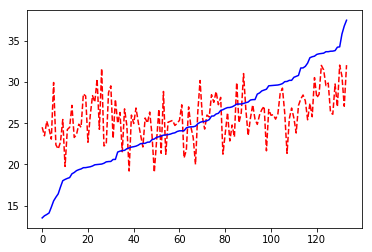

In [19]:
plt.figure()
plt.plot(y_all_sorted[predicted_name].values,'r--',y_all_sorted[LABEL].values,'b')

In [20]:
regressor.get_params()

{'params': {'activation_fn': <function tensorflow.python.ops.math_ops.tanh>,
  'dropout': 0.2,
  'embedding_lr_multipliers': None,
  'feature_columns': (_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float3

In [21]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:04:16


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-10-18-21:04:16
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 17.485
MSE train (tensorflow): 17.485006
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/angry_ConfidenceTanh2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2000


In [22]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 20.982423
R2 train (sklearn): 0.309279
MSE WTD train (sklearn): 18.763101
R2 WTD train (sklearn): 0.393198


Populating the interactive namespace from numpy and matplotlib


C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


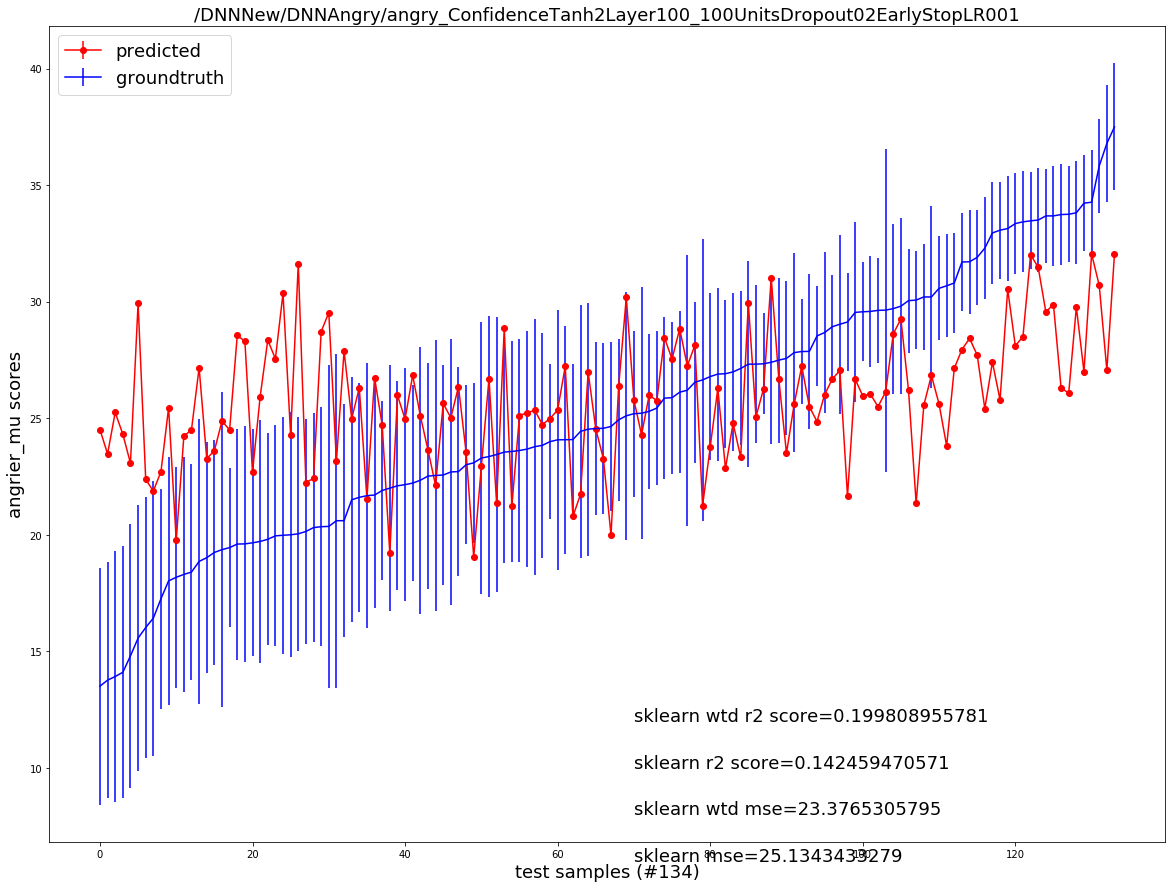

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_sorted[predicted_name].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [24]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


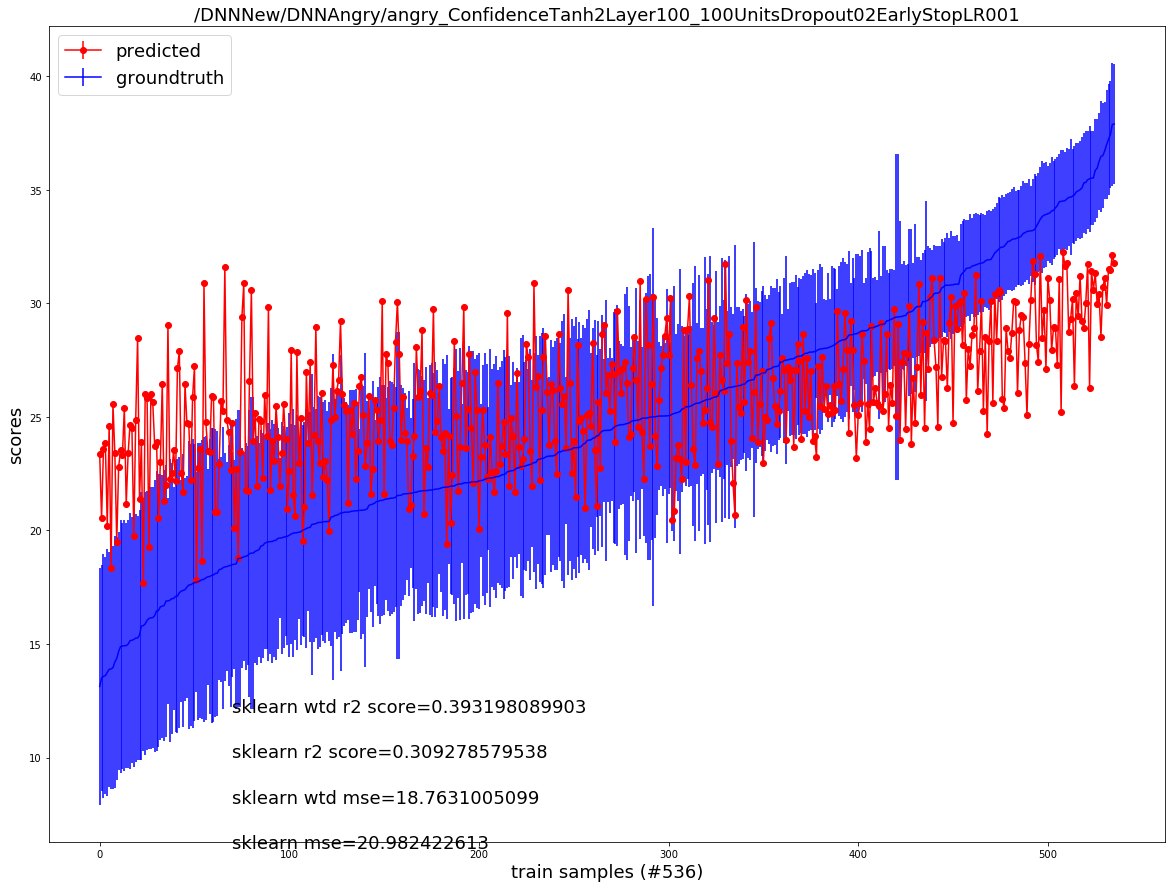

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)
plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 